This notebook serves as an initial exploration into NLP (specifically sentiment analysis). We will examine yelp reviews to try to train various neural networks to predict the amount of stars each review will have.

We map scale the number of stars down to a 0 - 1 scale, then train the model to predict a decimal number in that range. Then, we assign that number to a discrete integer from 1-5 (to match the stars) based on what percentile it is closest to in the training set. We make the training set evenly balanced between each numbe rof stars. For example, an "average" prediction would be classified as a 3, whereas a predicition that is 10th perentile among the training data would be classified as a 1. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from keras.losses import CategoricalCrossentropy
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Embedding, Conv1D,MaxPooling1D, Flatten, Dense,Dropout,LSTM,Bidirectional
#from keras.optimizers import RMSprop

### Load Data

In [4]:
data = pd.read_csv('yelp.csv')

In [5]:
data = data.dropna()
text = data['text'].tolist()
binstars = data['stars'].tolist()
binstars = [int(star) for star in binstars]

<AxesSubplot:ylabel='Count'>

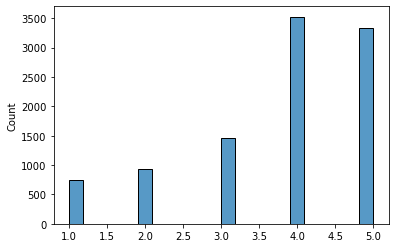

In [6]:
sns.histplot(x = binstars)

Note that these yelp reviews are heavily skewed -- more "accurate" models would be heavily biased toward 4s and 5s. However, our goal is to emulate learning/interpretation as best as possble. Thus, we will still train our data on a balanced dataset.

### Make a balanced dataset of reviews of different stars: 20% for each star count

In [7]:
balanced_texts = []  
balanced_labels = []  
all_texts = []
all_labels = []
balanced = []
count = 500  
stars = [0, 0, 0, 0, 0]
for i in range(len(text)):
    sentiment = binstars[i]
    if stars[sentiment-1] < count:
        balanced_texts.append(text[i])
        balanced_labels.append(binstars[i])
        balanced.append(i)
        stars[sentiment-1] += 1
    all_texts.append(text[i])
    all_labels.append(binstars[i])

In [8]:
# cut reviews after 200 words
maxlen = 200 
# Number of words to consider as features
# restrict the yelp reviews to the top 1000 most common words
max_words = 10000  

In [9]:
# create a tokenizer and it will ignore all except the 1000 most-common words
tokenizer = Tokenizer(num_words = max_words)
# use tokenizer to calculate the frequency of each word in dataset.
tokenizer.fit_on_texts(all_texts)
# convert all of reviews to lists of integers
sequences = tokenizer.texts_to_sequences(all_texts)
print(len(sequences[1]))
print(len(sequences[2]))


# use pad_sequence to make traning samples the same size, fill with zeros
data_input = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(all_labels)

260
15


### train and test (validation) split
We use 2500 training data (all balanced)
Our test data includes all 10000 data points (unbalanced)

In [10]:
indices = np.arange(data_input.shape[0])
data_input = data_input[indices]
labels = labels[indices]


x_train = np.asarray(data_input) [balanced]
y_train = np.asarray(labels) [balanced]
x_test = np.asarray(data_input)
y_test = np.asarray(labels)
print(" x_train",x_train.shape)
print(" y_train",y_train.shape)

y_train = y_train / 5
y_test = y_test / 5

 x_train (2500, 200)
 y_train (2500,)


 ### Model 1 - Using Embedding layer and LSTM

We start off with a simple Embedding + LSTM (long short-term memory) neural netowrk.
For all of our models, we will use mean_squared_error for both accuracy and loss for the initial prediction.

In [11]:
max_words = 10000 
maxlen = 200
model = Sequential()
model.add(Embedding(max_words, 64,input_length = maxlen))
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/5
16/16 [==============================] - 16s 627ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - val_loss: 0.1701 - val_mean_squared_error: 0.1701
Epoch 2/5
16/16 [==============================] - 9s 562ms/step - loss: 0.0673 - mean_squared_error: 0.0673 - val_loss: 0.1457 - val_mean_squared_error: 0.1457
Epoch 3/5
16/16 [==============================] - 9s 563ms/step - loss: 0.0603 - mean_squared_error: 0.0603 - val_loss: 0.1242 - val_mean_squared_error: 0.1242
Epoch 4/5
16/16 [==============================] - 10s 624ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0787 - val_mean_squared_error: 0.0787
Epoch 5/5
16/16 [==============================] - 11s 694ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss: 0.0793 - val_mean_squared_error: 0.0793


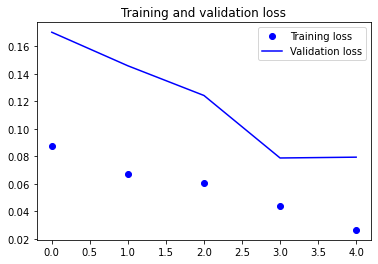

In [13]:
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
#plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 15s 47ms/step - loss: 0.0382 - mean_squared_error: 0.0382


[0.03819834813475609, 0.03819834813475609]

Now, we assign cutoffs for the 20th, 40th, 60th, and 80th percentiles (based on the training predictions).

In [15]:
train_pred = model.predict(x_train)
train_pred = np.reshape(train_pred, (2500,1))
train_pred = np.sort(train_pred, axis = 0)
print(train_pred[0])
print(train_pred[499])
print(train_pred[999])
print(train_pred[1499])
print(train_pred[1999])
print(train_pred[2499])
max1 = train_pred[499]
max2 = train_pred[999]
max3 = train_pred[1499]
max4 = train_pred[1999]
pd.DataFrame(train_pred).describe()

[0.23933488]
[0.43908587]
[0.57127327]
[0.7341324]
[0.8820386]
[0.98468864]


,0
count,2500.000000
mean,0.652214
std,0.206907
min,0.239335
25%,0.469886
50%,0.642322
75%,0.851232
max,0.984689


In [16]:
pred = model.predict(x_test)
pd.DataFrame(pred).describe()

,0
count,10000.000000
mean,0.713525
std,0.176436
min,0.239335
25%,0.578521
50%,0.739248
75%,0.865739
max,0.984689


In [18]:
pred = model.predict(x_test)
pred = np.where(pred < max1, 1, np.where(pred < max2, 2, np.where(pred < max3, 3, np.where(pred < max4, 4, 5))))
print(pd.DataFrame(pred).describe())
print(accuracy_score(labels, pred))
print(f1_score(labels,pred, average = 'macro'))
print(f1_score(labels,pred, average = 'weighted'))

                  0
count  10000.000000
mean       3.397100
std        1.222195
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
0.3914
0.3760855295885693
0.40411234418567066


Our model does better than random guessing. Note that our accuracy metrics are incredibly strict: for our purposes, we wish to predict the EXACT amount of stars a review will have, as we are treating the problem as a classification rather than a regression one.

Still, the accuracy metrics are around 0.4, so this is clearly an improvable model.

We try the same model as above, but with more epochs and more dropout (to combat overfitting)

In [27]:
max_words = 10000 
maxlen = 200
model = Sequential()
model.add(Embedding(max_words, 64,input_length = maxlen))
model.add(LSTM(64,dropout=0.25, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 64)           640000    
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
16/16 [==============================] - 16s 633ms/step - loss: 0.0837 - mean_squared_error: 0.0837 - val_loss: 0.1872 - val_mean_squared_error: 0.1872
Epoch 2/10
16/16 [==============================] - 10s 597ms/step - loss: 0.0693 - mean_squared_error: 0.0693 - val_loss: 0.1307 - val_mean_squared_error: 0.1307
Epoch 3/10
16/16 [==============================] - 9s 593ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.1190 - val_mean_squared_error: 0.1190
Epoch 4/10
16/16 [==============================] - 9s 582ms/step - loss: 0.0511 - mean_squared_error: 0.0511 - val_loss: 0.1248 - val_mean_squared_error: 0.1248
Epoch 5/10
16/16 [==============================] - 10s 642ms/step - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.0556 - val_mean_squared_error: 0.0556
Epoch 6/10
16/16 [==============================] - 10s 636ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0940 - val_mean_squared_error: 0.0940
Epoch 7/10
16/16 [======

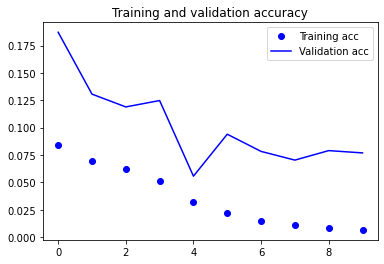

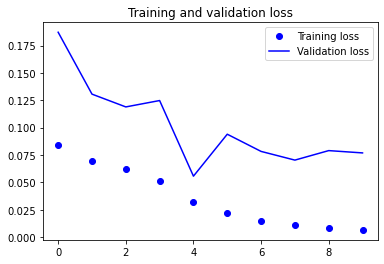

In [29]:
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 15s 49ms/step - loss: 0.0395 - mean_squared_error: 0.0395


[0.03945118561387062, 0.03945118561387062]

In [31]:
train_pred = model.predict(x_train)
train_pred = np.reshape(train_pred, (2500,1))
train_pred = np.sort(train_pred, axis = 0)
print(train_pred[0])
print(train_pred[499])
print(train_pred[999])
print(train_pred[1499])
print(train_pred[1999])
print(train_pred[2499])
max1 = train_pred[499]
max2 = train_pred[999]
max3 = train_pred[1499]
max4 = train_pred[1999]

pred = model.predict(x_test)
pred = np.where(pred < max1, 1, np.where(pred < max2, 2, np.where(pred < max3, 3, np.where(pred < max4, 4, 5))))
print(pd.DataFrame(pred).describe())
print(accuracy_score(labels, pred))
print(f1_score(labels,pred, average = 'macro'))
print(f1_score(labels,pred, average = 'weighted'))

[0.15175322]
[0.38360918]
[0.5710807]
[0.76871586]
[0.909233]
[0.9907366]
                  0
count  10000.000000
mean       3.353800
std        1.229625
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
0.4304
0.4200643805074982
0.4445347009511704


The initial evaluation (pre-classification) of this model was only slight better than the original, but we can see that our accuracy scores were all much better, all safely above 0.4, evidence that the additional epophcs and dropout helped the strength of the model without causing overfitting.

 ### Model 2 -  Using combination of CNN and RNN
 For this model, we use a convolutional model and then an LSTM.

In [32]:
model_conv = Sequential()
model_conv.add(Embedding(max_words, 128, input_length=maxlen))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=3))
model_conv.add(LSTM(128))
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_conv.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 dropout_1 (Dropout)         (None, 200, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 64)           41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 65, 64)           0         
 1D)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 128)               98816     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                      

In [33]:
history = model_conv.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
16/16 [==============================] - 13s 475ms/step - loss: 0.0766 - mean_squared_error: 0.0766 - val_loss: 0.1074 - val_mean_squared_error: 0.1074
Epoch 2/10
16/16 [==============================] - 8s 504ms/step - loss: 0.0665 - mean_squared_error: 0.0665 - val_loss: 0.1417 - val_mean_squared_error: 0.1417
Epoch 3/10
16/16 [==============================] - 9s 554ms/step - loss: 0.0562 - mean_squared_error: 0.0562 - val_loss: 0.1137 - val_mean_squared_error: 0.1137
Epoch 4/10
16/16 [==============================] - 8s 501ms/step - loss: 0.0351 - mean_squared_error: 0.0351 - val_loss: 0.0876 - val_mean_squared_error: 0.0876
Epoch 5/10
16/16 [==============================] - 7s 441ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0982 - val_mean_squared_error: 0.0982
Epoch 6/10
16/16 [==============================] - 7s 462ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0655 - val_mean_squared_error: 0.0655
Epoch 7/10
16/16 [=========

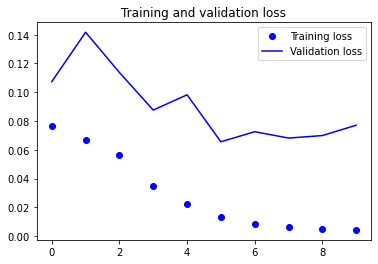

In [34]:
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
#plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
model_conv.evaluate(x_test, y_test)

313/313 [==============================] - 14s 45ms/step - loss: 0.0468 - mean_squared_error: 0.0468


[0.04681209847331047, 0.04681209847331047]

Our initial "regression" model is notably better here, almost getting to 0.5.

In [40]:
train_pred = model_conv.predict(x_train)
train_pred = np.reshape(train_pred, (2500,1))
train_pred = np.sort(train_pred, axis = 0)
print(train_pred[0])
print(train_pred[499])
print(train_pred[999])
print(train_pred[1499])
print(train_pred[1999])
print(train_pred[2499])
max1 = train_pred[499]
max2 = train_pred[999]
max3 = train_pred[1499]
max4 = train_pred[1999]

pred = model_conv.predict(x_test)
pred = np.where(pred < max1, 1, np.where(pred < max2, 2, np.where(pred < max3, 3, np.where(pred < max4, 4, 5))))
print(pd.DataFrame(pred).describe())
print(accuracy_score(labels, pred))
print(f1_score(labels,pred, average = 'macro'))
print(f1_score(labels,pred, average = 'weighted'))

[0.14569229]
[0.3773192]
[0.5512589]
[0.7384934]
[0.8944385]
[0.99736154]
                  0
count  10000.000000
mean       3.280400
std        1.226999
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
0.4096
0.40024345956097857
0.42720843169094025


However, the classification power of this model is not necessarily better than the previous one. This model does seem to predict slightly lower star values than the last, so the classification could have been messed up by a poor construction of percentiles from the training data.

#  Using bidirectional RNNs
We construct a simple LSTM RNN, except we make it bidirectional. This allows the model to consider forward and backward relations between words.

In [41]:
from keras import backend as K
K.clear_session()

In [42]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,543,425
Trainable params: 1,543,425
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
16/16 [==============================] - 57s 3s/step - loss: 0.0770 - mean_squared_error: 0.0770 - val_loss: 0.1222 - val_mean_squared_error: 0.1222
Epoch 2/10
16/16 [==============================] - 51s 3s/step - loss: 0.0655 - mean_squared_error: 0.0655 - val_loss: 0.1109 - val_mean_squared_error: 0.1109
Epoch 3/10
16/16 [==============================] - 52s 3s/step - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.0709 - val_mean_squared_error: 0.0709
Epoch 4/10
16/16 [==============================] - 50s 3s/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0831 - val_mean_squared_error: 0.0831
Epoch 5/10
16/16 [==============================] - 52s 3s/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0708 - val_mean_squared_error: 0.0708
Epoch 6/10
16/16 [==============================] - 51s 3s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.1082 - val_mean_squared_error: 0.1082
Epoch 7/10
16/16 [======================

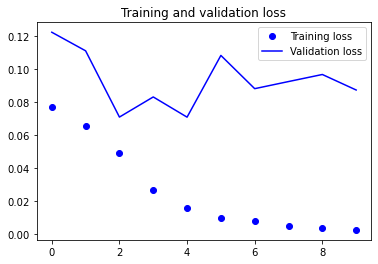

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline 
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
#plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [45]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 47s 151ms/step - loss: 0.0442 - mean_squared_error: 0.0442


[0.04418960586190224, 0.04418960586190224]

Pretty good initial predictions, almost as good as the CNN + RNN model

In [46]:
train_pred = model.predict(x_train)
train_pred = np.reshape(train_pred, (2500,1))
train_pred = np.sort(train_pred, axis = 0)
print(train_pred[0])
print(train_pred[499])
print(train_pred[999])
print(train_pred[1499])
print(train_pred[1999])
print(train_pred[2499])
max1 = train_pred[499]
max2 = train_pred[999]
max3 = train_pred[1499]
max4 = train_pred[1999]

[0.15175322]
[0.38360918]
[0.5710807]
[0.76871586]
[0.909233]
[0.9907366]

pred = model.predict(x_test)
pred = np.where(pred < max1, 1, np.where(pred < max2, 2, np.where(pred < max3, 3, np.where(pred < max4, 4, 5))))
print(pd.DataFrame(pred).describe())
print(accuracy_score(labels, pred))
print(f1_score(labels,pred, average = 'macro'))
print(f1_score(labels,pred, average = 'weighted'))

[0.12602794]
[0.38806078]
[0.58063126]
[0.7796544]
[0.9294343]
[0.998315]
                  0
count  10000.000000
mean       3.286200
std        1.242274
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
0.4252
0.4148024904850791
0.44164699398847423


The classification seems to be around as good as the initial 10-epoch RNN, based on our accuracy. Given the strong performance pre-classification, this seems to be the best model. 

# Using New Data
We use a new large dataset to test our bidirectional model. This dataset has many, many entries -- we will only use a relatively small (size 100000) portion due to computational time.

In [48]:
newdata = pd.read_json('yelp_academic_dataset_review.json', lines = True, encoding_errors = 'ignore', nrows = 100000)
newdata.describe()

,stars,useful,funny,cool
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.842910,0.898980,0.257180,0.347030
std,1.354729,2.205186,1.010212,1.066382
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,320.000000,98.000000,49.000000


In [49]:
newtext = newdata['text'].tolist()
newstars = newdata['stars'].tolist()
newstars = [float(star) for star in newstars]

newsequences = tokenizer.texts_to_sequences(newtext)
print(len(newsequences[1]))
print(len(newsequences[2]))
newdata_input = pad_sequences(newsequences, maxlen = maxlen)

144
54


In [50]:
newdata_labels = np.asarray(newstars)
newdata_labels = newdata_labels/5
newdata_input = np.asarray(newdata_input)
#newdata_labels = np.where(newdata_labels < 0.21, 0.2, np.where(newdata_labels < 0.41, 0.4, np.where(newdata_labels < 0.61, 0.6, np.where(newdata_labels < 0.81, 0.8, 1.0))))
print(newdata_input[:10])
print(newdata_labels[:10])

[[   0    0    0 ...   32  400 5862]
 [   0    0    0 ... 2919   11 1144]
 [   0    0    0 ...    5    1  512]
 ...
 [   0    0    0 ...   17 1700 1357]
 [   0    0    0 ...  172   66 2091]
 [   0    0    0 ...  521   50   65]]
[0.6 1.  0.6 1.  0.8 0.2 1.  1.  0.6 0.6]


In [51]:
pred = model.predict(newdata_input)
pred = np.where(pred < max1, 1, np.where(pred < max2, 2, np.where(pred < max3, 3, np.where(pred < max4, 4, 5))))
print(pd.DataFrame(pred).describe())
print(accuracy_score(newstars, pred))
print(f1_score(newstars,pred, average = 'macro'))
print(f1_score(newstars,pred, average = 'weighted'))


                   0
count  100000.000000
mean        3.317550
std         1.246895
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
0.33672
0.3174306534359467
0.36723599380378424


Even though this does worse than the initial dataset we used (as expected), the results are still decent. The gap between the macro f1_score and the weighted f1_score imply that the data was heavily skewed and that our model at least did a decent job of predicting the less common star values.

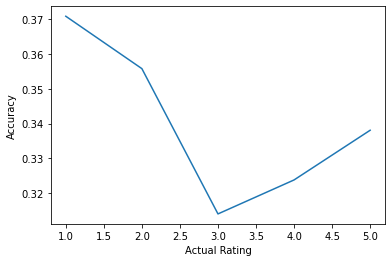

In [52]:
corr = [0,0,0,0,0,0]
tot = [0,0,0,0,0,0]
for i in range(len(pred)):
    if newstars[i] == pred[i]:
        corr[int(newstars[i])] += 1
    tot[int(newstars[i])] += 1
    
plt.plot(np.asarray(corr)/np.asarray(tot))
plt.ylabel('Accuracy')
plt.xlabel('Actual Rating')
plt.show()

Based on the graph, we can see that the model does the best at predicting 1 and 2 star reviews, and does the worse with 3 star reviews. We can hypothesize that negative words are easier to spot. It also makes sense that 3 star reviews would be hard to predict - it's hard to think of many specific words that would indicate a 3 star review.